# Omnigenity Optimization

This tutorial demonstrates how to optimize for omnigenity in DESC. It will go through an example using omnigenity with poloidally closed contours of magnetic field strength (OP), but the method is capable of optimizing for any general omnigenous magnetic fields as explain in [Dudt et al. (2024)](https://arxiv.org/abs/2305.08026).

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

If you have access to a GPU, uncomment the following two lines. 

In [2]:
# from desc import set_device
# set_device("gpu")

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 12

import numpy as np
from qic import Qic

from desc.equilibrium import Equilibrium
from desc.grid import LinearGrid
from desc.magnetic_fields import OmnigenousField
from desc.objectives import (
    AspectRatio,
    CurrentDensity,
    ObjectiveFunction,
    FixCurrent,
    FixPressure,
    FixPsi,
    GenericObjective,
    Omnigenity,
    get_NAE_constraints,
)
from desc.optimize import Optimizer
from desc.plotting import plot_boozer_surface, plot_boundaries, plot_omnigenous_field

DESC version 0.10.2+278.g2b152e6f.dirty,using JAX backend, jax version=0.4.11, jaxlib version=0.4.11, dtype=float64
Using device: CPU, with 10.57 GB available memory


As an initial guess for the optimization, we will start with a solution from the near-axis expansion code pyQIC. 
This is a vacuum magnetic field with two field periods, $N_{FP}=2$. 
Near-axis expansion solutions must be evaluated at a particular minor radius, and in this case it is chosen to give an aspect ratio of $R_0/a \approx 10$. 

In [4]:
# load near axis expansion solution
qic = Qic.from_paper("QI NFP2 r2")

# create a DESC Equilibrium from the pyQIC solution, evaluated at a minor radius of a=0.1 m
eq = Equilibrium.from_near_axis(qic, M=8, r=0.1)
# the major radius is R0=1 m, so this will have an aspect ratio of about R0/a=10

When evaluated at a finite aspect ratio, the near-axis expansion solution is not a good equilibrium solution. 
Therefore we re-solve the vacuum equilibrium, while maintaining the first-order near-axis constraints: 

In [5]:
# re-solve with near-axis expansion (NAE) constraints
constraints = get_NAE_constraints(eq, qic, order=1)
eq, _ = eq.solve(objective="vacuum", constraints=constraints, verbose=3)

Building objective: current density
Precomputing transforms
Timer: Precomputing transforms = 927 ms
Timer: Objective build = 3.45 sec
Timer: Linear constraint projection build = 5.75 sec
Compiling objective function and derivatives: ['current density']
Timer: Objective compilation time = 1.67 sec
Timer: Jacobian compilation time = 5.32 sec
Timer: Total compilation time = 7.00 sec
Number of parameters: 1020
Number of objectives: 6825
Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          2.303e+00                                    1.612e+03   
       1              4          1.149e+00      1.154e+00      2.368e-01      5.914e+02   
       2              5          4.211e-01      7.279e-01      1.500e-01      4.335e+02   
       3              7          2.641e-01      1.570e-01      8.819e-02      1.283e+02   
       4              8          2.623e-01      1.837e-03     

Let us make a copy of this initial equilibrium so that we can compare our final solution to it later and see how well the omnigenity optimization worked. 
By plotting the $|B|$ contours in Boozer coordinates, we can see that this equilibrium is already close to being omnigenous but far from perfect. 

(<Figure size 576.078x576.078 with 2 Axes>,
 <AxesSubplot: title={'center': '$|\\mathbf{B}|~(T)$'}, xlabel='$\\zeta_{Boozer}$', ylabel='$\\theta_{Boozer}$'>)

/home/dudt/anaconda3/envs/desc/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


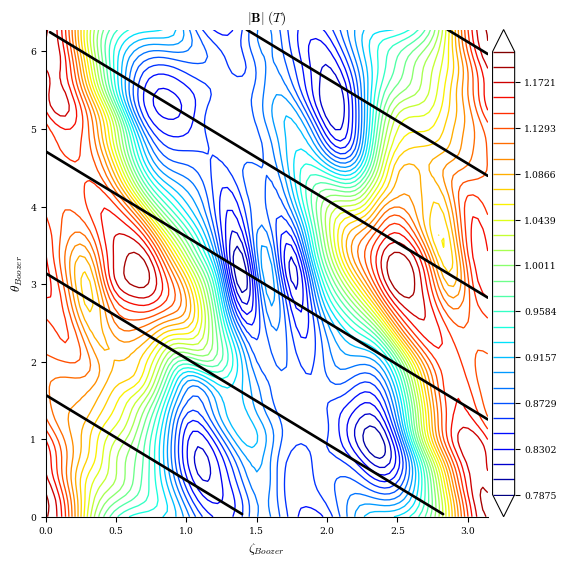

In [6]:
eq0 = eq.copy()
plot_boozer_surface(eq0, fieldlines=4)

In order to optimize the Equilibrium for omnigenity, we need to create an omnigenous magnetic field object. 
The `OmnigenousField` class has two attributes that represent parameters in the omnigenous magnetic field model: 
- `B_lm` specifies the shape of the "magnetic well" on each flux surface
- `x_lmn` specifies how the well shape varies along different field lines
In this example, the field will be initialized with default parameters and they will become free variables during the optimization. 

We do need to specify the resolution of the parameter space and the helicity of the field. 
The helicity is given by the tuple of integers $(M, N)$, and is set to $(0, N_{FP})$ for omnigenity with poloidal contours in this example. 
The typical case for helical contours would be $(1, N_{FP})$, and for toroidal contours would be $(1, 0)$. 

In [7]:
field = OmnigenousField(
    L_well=1,  # radial resolution of B_lm parameters
    M_well=8,  # number of spline knots on each flux surface
    L_omni=1,  # radial resolution of x_lmn parameters
    M_omni=2,  # poloidal resolution of x_lmn parameters
    N_omni=2,  # toroidal resolution of x_lmn parameters
    NFP=eq.NFP,  # number of field periods; should always be equal to Equilibrium.NFP
    helicity=(0, eq.NFP),  # helicity for poloidally closed |B| contours
)

Next we create the objective function ...

In [8]:
objective = ObjectiveFunction(
    (
        GenericObjective("R0", eq=eq, target=1.0),  # target major radius of R0=1 m
        AspectRatio(eq=eq, bounds=(0, 10)),  # target aspect ratio R0/a<=10
        Omnigenity(field=field, eq=eq, rho=0.5),  # omnigenity on the rho=0.5 surface
        Omnigenity(field=field, eq=eq, rho=1.0),  # omnigenity on the rho=1.0 surface
    )
)

Then we set the constraints ...

In [9]:
constraints = (
    CurrentDensity(eq=eq),  # vacuum equilibrium
    FixPressure(eq=eq),
    FixCurrent(eq=eq),
    FixPsi(eq=eq),
)

Finally we run the optimization ...

In [10]:
optimizer = Optimizer("lsq-auglag")
(eq, field), _ = optimizer.optimize((eq, field), objective, constraints, verbose=3)

Building objective: generic
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 59.1 ms
Building objective: omnigenity
Precomputing transforms
Timer: Precomputing transforms = 228 ms
Timer: Objective build = 494 ms
Building objective: current density
Precomputing transforms
Timer: Precomputing transforms = 133 ms
Timer: Objective build = 351 ms
Timer: Linear constraint projection build = 2.02 sec
Timer: Linear constraint projection build = 660 ms
Compiling objective function and derivatives: ['generic', 'aspect ratio', 'omnigenity']
Timer: Objective compilation time = 2.19 sec


: 

In [ ]:
grid = LinearGrid(M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP, sym=eq.sym)
iota = eq.compute("iota", grid=grid)["iota"][0]
plot_omnigenous_field(field, iota, fieldlines=4)
plot_boozer_surface(eq, fieldlines=4)

In [ ]:
plot_boundaries((eq0, eq), labels=["Initial", "Optimized"])